# In this notebook we will work on predicting the value of football players. The dataset that we are basing this analysis on is from kaggle: https://www.kaggle.com/datasets/kriegsmaschine/soccer-players-values-and-their-statistics

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
import seaborn as sns
import matplotlib as mpl

In [65]:
# Constructing the path using os.path.join
#C:\Users\samue\ -  Path for desktop
base_path = r"C:\Users\didov\OneDrive\Documents\GitHub\hsaalen-datamining" #Path for Laptop
sub_path = "Regression"
folder_name = "football-data"


# 0. Data load

In [66]:
# Loading the data
filenames = ["transfermarkt_fbref_201718", "transfermarkt_fbref_201819", "transfermarkt_fbref_201920"]

path = os.path.join(base_path, sub_path, folder_name)
print(f"Working in path: {path}")

# Construct file paths and read the CSV files
dfs = []
for i, file in enumerate(filenames):
    data = pd.read_csv(os.path.join(path, file + ".csv"),delimiter=';', thousands=',') # Read the CSV file and set the delimiter to ';' and the thousands separator to ',' (had to be done because some numbers were in the format 1,000)
    data['year']=2017+i # Adding a column for the year of the data
    dfs.append(data) # Appending the dataframe to the list of dataframes
    
df = pd.concat(dfs) # Turning the list of dataframes into one dataframe
data = df.copy() # Creating a copy of the dataframe for later use

print("--------------------------------------")
print(f"Amount of samples: {len(df)}. Amount of features: {len(df.columns)}")
print("--------------------------------------")


Working in path: C:\Users\didov\OneDrive\Documents\GitHub\hsaalen-datamining\Regression\football-data
--------------------------------------
Amount of samples: 7108. Amount of features: 402
--------------------------------------


# 1. Data Overview

In [67]:
# Trying to understand the Data
# Looking at the first row to see what columns we have and what kind of values those hold
print("Data Information")
print(df.info())
print("--------------------------------------")
columns = df.columns.values
print(f"Columns: {columns}")

Data Information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7108 entries, 0 to 2643
Columns: 402 entries, Unnamed: 0 to Column1
dtypes: float64(393), int64(1), object(8)
memory usage: 21.9+ MB
None
--------------------------------------
Columns: ['Unnamed: 0' 'player' 'nationality' 'position' 'squad' 'age' 'birth_year'
 'value' 'height' 'position2' 'foot' 'league' 'games' 'games_starts'
 'minutes' 'goals' 'assists' 'pens_made' 'pens_att' 'cards_yellow'
 'cards_red' 'goals_per90' 'assists_per90' 'goals_assists_per90'
 'goals_pens_per90' 'goals_assists_pens_per90' 'xg' 'npxg' 'xa' 'xg_per90'
 'xa_per90' 'xg_xa_per90' 'npxg_per90' 'npxg_xa_per90' 'minutes_90s'
 'shots_total' 'shots_on_target' 'shots_free_kicks' 'shots_on_target_pct'
 'shots_total_per90' 'shots_on_target_per90' 'goals_per_shot'
 'goals_per_shot_on_target' 'npxg_per_shot' 'xg_net' 'npxg_net'
 'passes_completed' 'passes' 'passes_pct' 'passes_total_distance'
 'passes_progressive_distance' 'passes_completed_short' 'pass

In [68]:
# Set display options to show all rows
pd.set_option('display.max_rows', None)
columns_overview = df.sample(1).T # Transpose the dataset to get a better overview. Also, display some random rows to get a proper understanding of the data.
print(columns_overview)

# Reset the display options after printing
pd.reset_option('display.max_rows')

                                                                  481
Unnamed: 0                                                      300.0
player                                                   Valter Birsa
nationality                                                    si SVN
position                                                        MF,FW
squad                                                          Chievo
age                                                              30.0
birth_year                                                     1986.0
value                                                       4000000.0
height                                                          184.0
position2                               midfield - Attacking Midfield
foot                                                             left
league                                                        Serie A
games                                                            35.0
games_starts        

Transforming the column "position" into a column that holds a value for the amount of positions a player can play

In [64]:
print("Missing values in the column position")
missing_values= df['position'].isnull().sum()
print(missing_values.sum())
missing_position_rows = df[df['position'].isna()]

# Fill missing values with an empty string (indicating no position)
df['position'] = df['position'].fillna('')

# Count the number of positions each player can play
df['positions_played'] = df['position'].str.split(',').apply(lambda x: len(x) if x[0] != '' else 0)


Missing values in the column position
0


Splitting the column "position2" into two sperate columns "position_type" and "specific_position"

In [57]:
# Splitting the "position2" column into two separate columns: "position_type" and "specific_position"
df[["position_type", "specific_position"]] = df["position2"].str.split(" - ", expand=True)

# Dropping the "position2" column
df.drop(columns=["position2"], inplace=True)

In [59]:
df['position']

0       FW,MF
1          DF
2          DF
3          DF
4          MF
        ...  
2639    FW,MF
2640       DF
2641    FW,MF
2642       DF
2643       DF
Name: position, Length: 7108, dtype: object

In [23]:
print("Missing values in entire dataset")
missing_values= df.isnull().sum()
print(missing_values.sum())

Missing values in entire dataset
84368


# 2. Removing Features 

We have 400 Features which is quite a few. It will be necessary to remove some. One way of doing this is computing the correlation matrix. This is the correlation between features. So, we compare pairs and if a pair has high correlation that means that they are similar. They both hold information that will influence the model in the same way.

In [33]:
# Function to calculate and visualize the correlation matrix
def visualize_corr_matrix(df, target_col="value"):
    """
    Calculate and visualize the correlation matrix of a DataFrame excluding the target column.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the features.
    target_col (str): The name of the target column to be excluded from correlation calculations.
    
    Returns:
    corr_matrix (pd.DataFrame): The correlation matrix of the features.
    """
    # Exclude the target column
    features_df = df.drop(columns=[target_col])
    
    # Select only numeric columns for correlation matrix calculation
    numeric_df = features_df.select_dtypes(include=[np.number])
    
    # Calculate the absolute value of the correla'tion matrix
    corr_matrix = numeric_df.corr()
    
    # Increase the figure size
    plt.figure(figsize=(20, 16))

    # Plot the heatmap
    sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
    plt.title("Correlation Matrix Heatmap")
    plt.show()
        
    return corr_matrix


# Function to remove highly correlated features
def remove_highly_correlated_features(df, threshold=0.9):
    """
    Remove highly correlated features from a DataFrame.

    This function calculates the correlation matrix of the DataFrame and removes one feature 
    from each pair of features that have a correlation coefficient greater than the specified threshold. 
    This helps in reducing multicollinearity in the dataset, which can improve the performance of 
    machine learning models.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the features.
    threshold (float): The correlation coefficient threshold above which features are considered highly correlated. 
                       Default value is 0.9.

    Returns:
    df_reduced (pd.DataFrame): The DataFrame with highly correlated features removed.
    to_drop (list): A list of the names of the features that were removed.

    Example:
    df_reduced, dropped_features = remove_highly_correlated_features(df, threshold=0.85)
    """
    # Select only numeric columns for correlation matrix calculation
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Calculate the absolute value of the correlation matrix
    corr_matrix = numeric_df.corr().abs()
    
    # Select the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find index of feature columns with correlation greater than the threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Drop the highly correlated features
    df_reduced = df.drop(columns=to_drop)
    
    return df_reduced, to_drop


def calculate_corr_to_targe(df, target_col="value"):
    """
    Calculate the correlation of each feature with the target column.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the features and target column.
    target_col (str): The name of the target column. Default is "value".

    Returns:
    corr_to_target (pd.Series): The correlation of each feature with the target column.
    """
    # Calculate the correlation of each feature with the target column
    corr_to_target = df.corr()[target_col].abs()
    
    return corr_to_target

Looking at the correlation matrix to see whether some features are "redundant". We can define a threshold when using the method "remove_highly_correlated_features" that will remove one feature from a highly correlated pair.

In [46]:
corr_to_target = calculate_corr_to_targe(df)
plt.figure(figsize=(20, 16))
plt.plot(corr_to_target.values, 'o-')  # Plot the correlation values
plt.show()

ValueError: Length of values (395) does not match length of index (7108)

In [47]:
calculate_corr_to_targe(df).values.shape

(395,)

In [48]:
df.shape

(7108, 403)

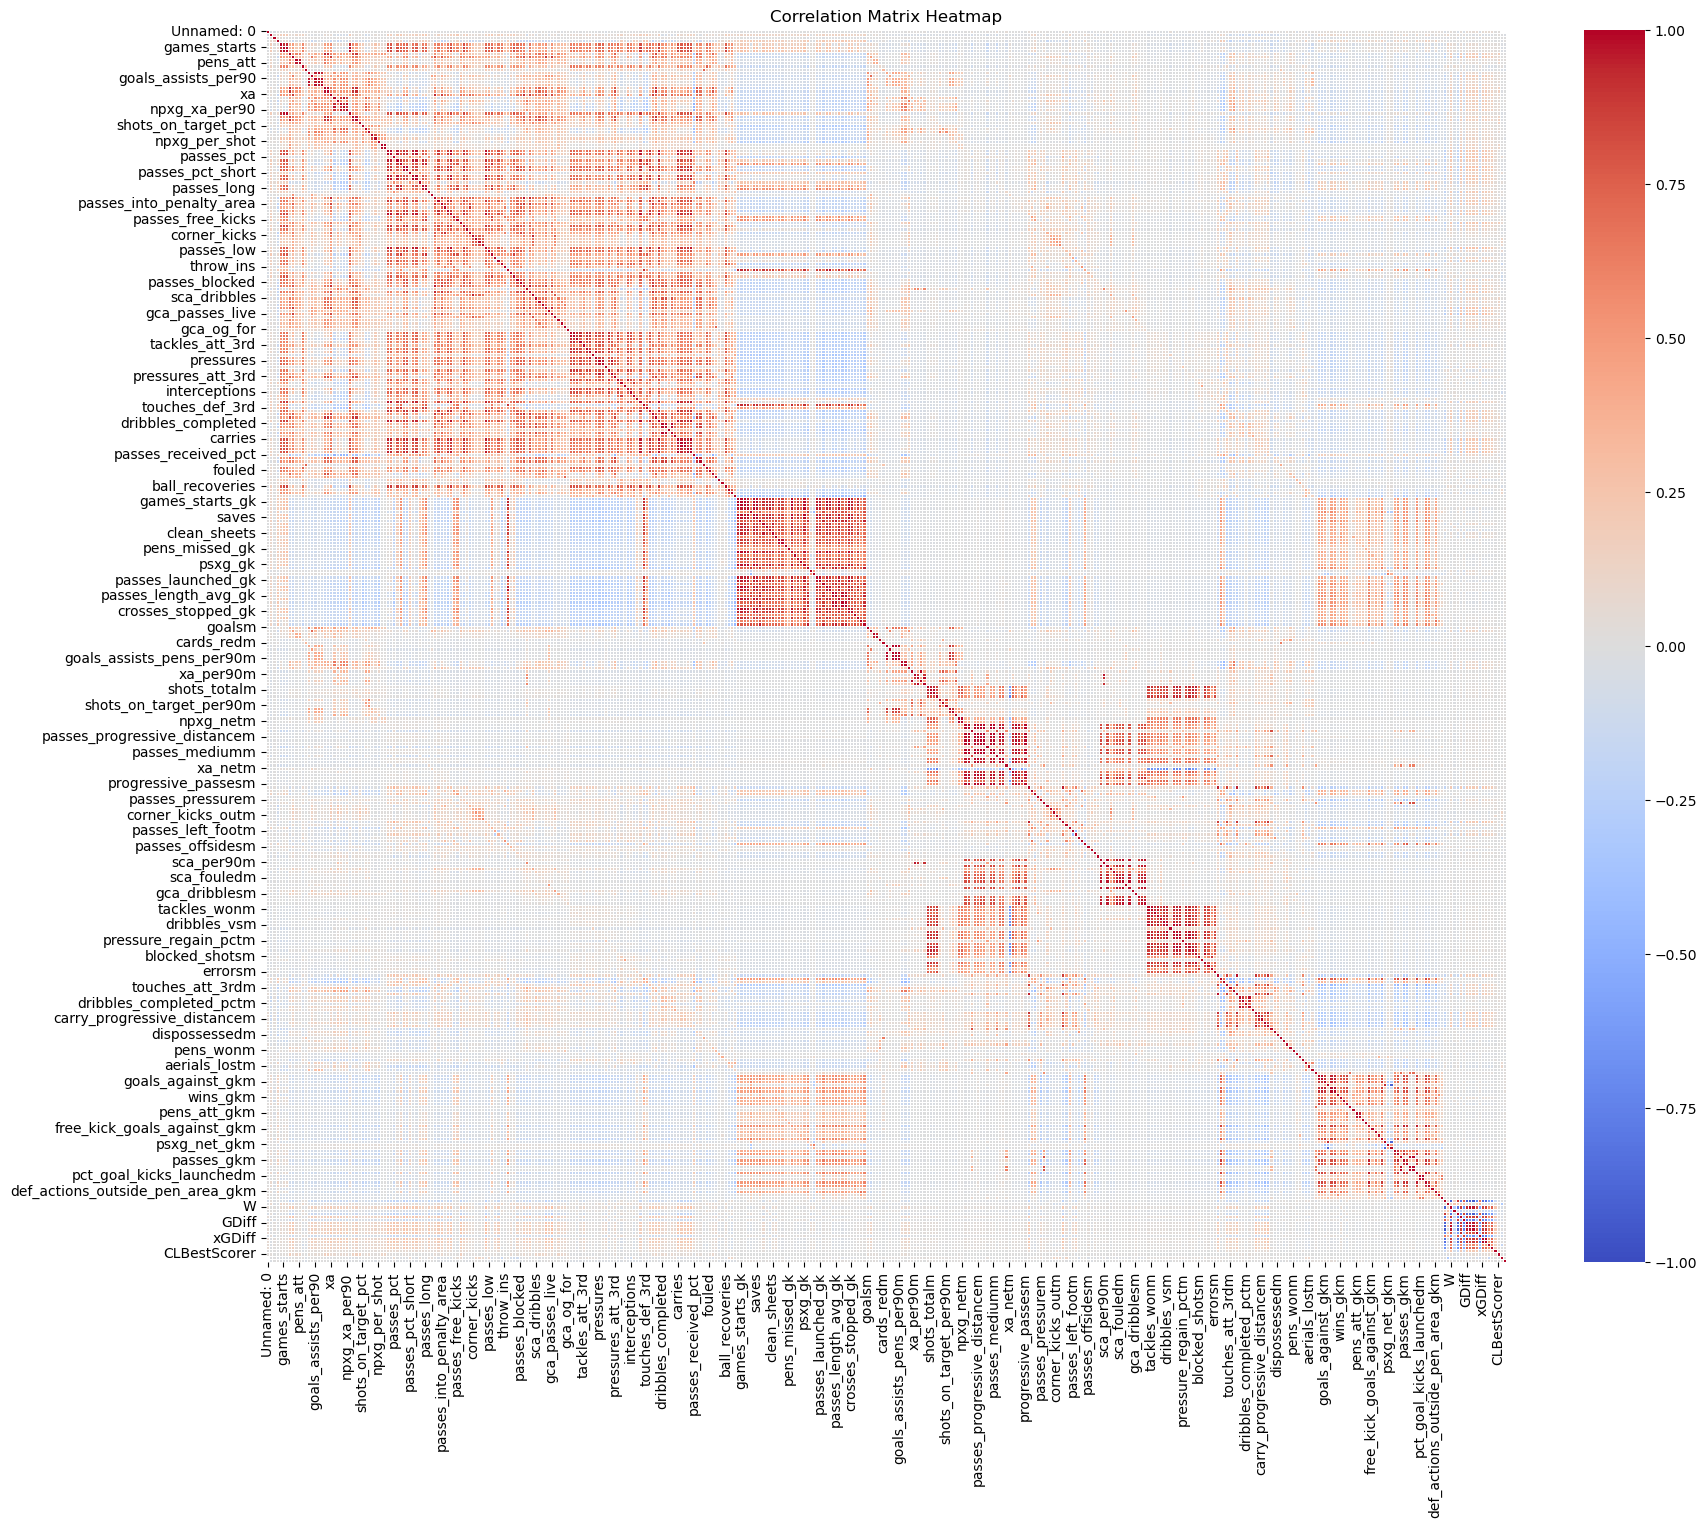

In [35]:
# Visualize the correlation matrix, excluding the target column 'value'
corr_matrix = visualize_corr_matrix(df, target_col='value')

# 3. Splitting Data

Given that new data will always be the upcoming year, I used StratifiedShuffleSplit to have a well distributed train and test set by year.

In [39]:
from sklearn.model_selection import StratifiedShuffleSplit

# Sample DataFrame (replace with actual data loading)
df = pd.DataFrame(data)  # Replace 'data' with your actual data loading step

# Check the current index of the DataFrame
print("Current Index:")
print(df.index)

# If needed, reset the index
if not df.index.is_integer():
    df.reset_index(drop=True, inplace=True)

# Check the index after resetting
print("\nIndex After Reset:")
print(df.index)

# Initialize StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_index, test_index in split.split(df, df['year']):  # Stratification column
    train_set = df.iloc[train_index]
    test_set = df.iloc[test_index]

# Display the resulting sets
print("\nTraining Set:")
print(train_set.shape)
print("--------------------------------------")

print("\nTest Set:")
print(test_set.shape)
print("--------------------------------------")

Current Index:
RangeIndex(start=0, stop=2644, step=1)

Index After Reset:
RangeIndex(start=0, stop=2644, step=1)

Training Set:
(2115, 401)
--------------------------------------

Test Set:
(529, 401)
--------------------------------------
